In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import namedtuple
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score,make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

import matplotlib.pyplot as plt
from collections import Counter ,OrderedDict
from itertools import compress
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.model_selection import GridSearchCV
from pandas.plotting import scatter_matrix
# Import supplementary visualizations code visuals.py
import visuals as vs

%matplotlib inline

In [2]:
Dataset=namedtuple('Dataset','exchange df')
DatasetMLModel= namedtuple('DatasetMLModel','exchange  train_size tscv_split test_size X_train y_train X_test y_test scaler_features scaler_target')
Regressor= namedtuple('Regressor','name regressor_class params type')
FeatureSelection= namedtuple('FeatureSelection','dataset regressor params RFECV')

In [3]:
with open('datasets/log_divided_close_datasets.pkl', 'rb') as input4:
    log_divided_close_datasets = pickle.load(input4)   
    

In [4]:
def drop_the_last_row(dataset):
    dataset.df.drop(dataset.df.index[-1], inplace=True)
    return dataset
def making_targets(dataset):
    column_targets=['Returns','close','log_return']
    for column_target in column_targets:
        dataset.df[column_target+'_Target']=dataset.df[column_target].shift(-1)
    return drop_the_last_row(dataset)

def building_series_to_each_input(dataset,N=15,column_series=['close']):  
    for n in range(1,N+1):
        for column in column_series:
            dataset.df[column+'_{0:02d}'.format(n)]=dataset.df[column].shift(n)
    
    dataset.df.drop(dataset.df.index[:n], inplace=True)
    return dataset

def building_series_to_each_input_log_return(dataset,N=15):
    return building_series_to_each_input(column_series=['log_return'])

def building_series_to_each_input_log_return(dataset,N=15):
    return building_series_to_each_input(column_series=['Returns'])

def make_X_Y(dataset , train_size,features=['close'],target=['close_Target']):    
    X_train=dataset.df[features][:train_size]
    y_train=dataset.df[target][:train_size]
    X_test=dataset.df[features][train_size:]
    y_test=dataset.df[target][train_size:]
    return X_train,y_train,X_test,y_test

def scaler(X_train,y_train,X_test,y_test):   
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    scaled_X_train=scaler_features.fit_transform(X_train)
    scaled_X_test=scaler_features.transform(X_test)
    X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=X_test.columns)
    scaled_y_train=scaler_target.fit_transform(y_train)
    scaled_y_test=scaler_target.transform(y_test)
    y_train = pd.DataFrame(scaled_y_train, index=y_train.index, columns=y_train.columns)
    y_test = pd.DataFrame(scaled_y_test, index=y_test.index, columns=y_test.columns)
    
    return X_train,y_train,X_test,y_test, scaler_features,scaler_target


def preprossessing(dataset,features,target, train_percent=0.80,evaluation_percent=0.20  ):
    rows, columns=dataset.df.shape
    train_size= int(rows*train_percent)
    tscv_split=int(rows//(train_size*evaluation_percent)-1)
    test_size=rows-train_size
    X_train,y_train,X_test,y_test=make_X_Y(dataset,train_size,features,target)
    X_train,y_train,X_test,y_test, scaler_features,scaler_target=scaler( X_train,y_train,X_test,y_test)
    return DatasetMLModel(dataset.exchange,train_size ,tscv_split,test_size,
                          X_train,y_train,X_test,y_test,scaler_features=None,scaler_target=None)






array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0ae901d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1b0a7630>]], dtype=object)

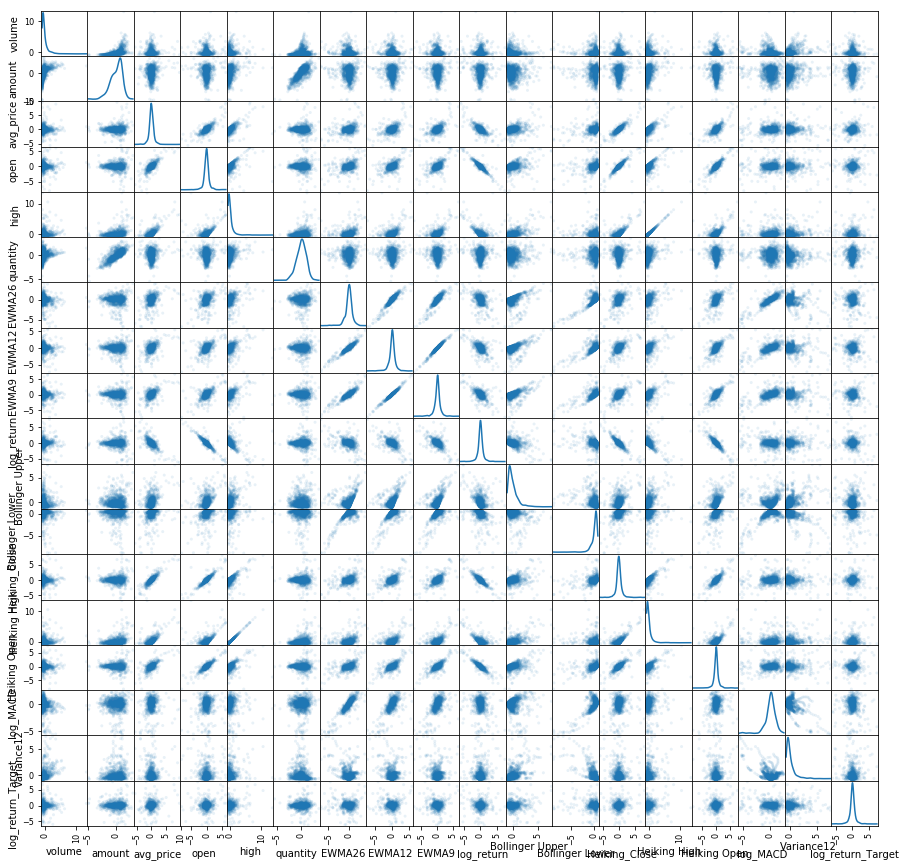

In [5]:
features=['volume','amount', 'avg_price','open','high','quantity',
          'EWMA26','EWMA12','EWMA9','log_return',
          'Bollinger Upper', 'Bollinger Lower','Heiking_Close','Heiking High',
          'Heiking Open','log_MACD','Variance12']
target=['log_return_Target']

#dataset.df[features][]
dataset=making_targets(log_divided_close_datasets['btc_brl'])
dataset= preprossessing(dataset,features,target)
df_to_plot=pd.concat([dataset.X_train,dataset.y_train],axis=1)
scatter_matrix(df_to_plot,alpha=0.1,figsize=(15,15), diagonal = 'kde')


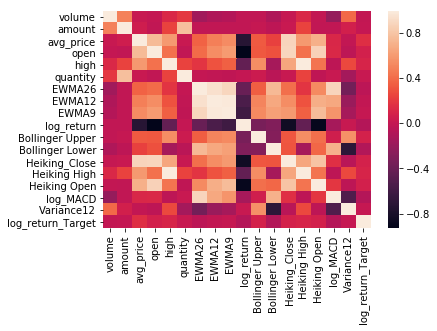

In [6]:
import seaborn as sns;
ax = sns.heatmap(df_to_plot.corr(method='pearson'))

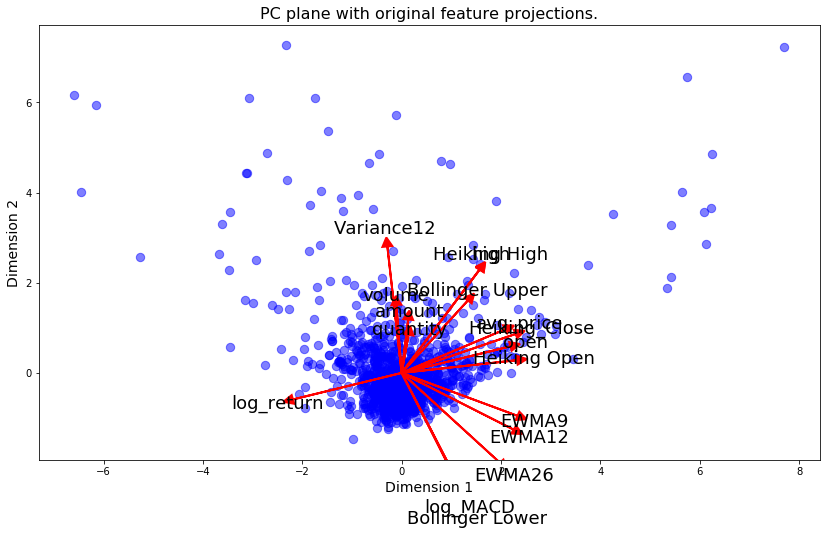

In [7]:
from sklearn.decomposition import PCA
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2,  whiten=True)
pca.fit(dataset.X_train)
# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(dataset.X_train)
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
vs.biplot(dataset.X_train, reduced_data, pca)

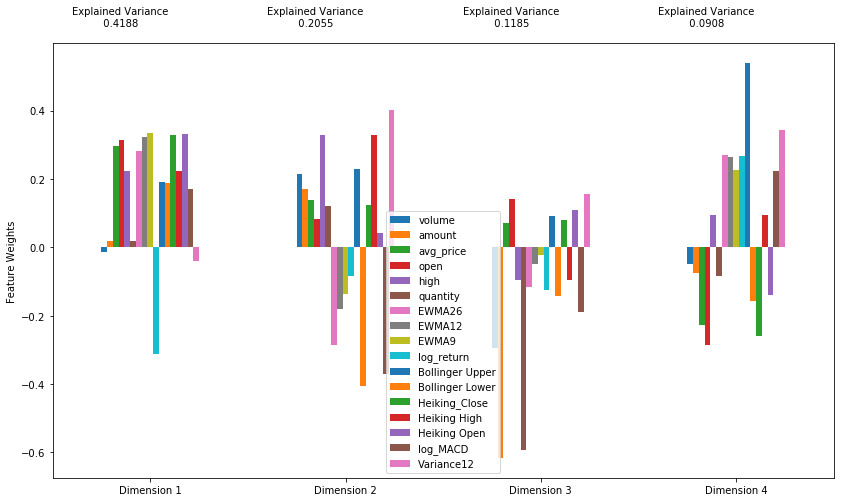

In [8]:

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=4, whiten=True,iterated_power=7)
# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.fit(dataset.X_train)

# Generate PCA results plot
pca_results = vs.pca_results(dataset.X_train, pca)

In [9]:
kernels = [ConstantKernel(1.0, (1e-3, 1e3))* RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           ConstantKernel(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.0, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

In [10]:
parameters_per_regressor={
     'SVR': {'C': [0.4],
           'gamma': [0.005,0.01], 
           'kernel': ['poly'],
           'degree': [2],
            'epsilon':[0.2],
           'max_iter':[15000]},
   'KernelRidge': {'alpha':range(135000,145000,500),
                   'gamma': [1],
                   'degree': [2],
                   'kernel': [ 'poly']},
    'GradientBoostingRegressor':{'loss' : ['huber'],
                             'n_estimators':[49,50,51],
                             'alpha':[0.01,0.05,0.1,0.13,0.15],
                             'max_depth':[2,3]
                            },
    'AdaBoostRegressor':{'base_estimator':[SVR(C=0.01, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1), max_iter=-1,
  shrinking=True)],#gamma=0.009->0.000948
                      'n_estimators':range(50,600,50)},    
    # 'AdaBoostRegressor':{'base_estimator':[SVR(C=0.01,gamma=0.01,kernel='rbf',degree=2)],#gamma=0.009->0.000948
    #                  'n_estimators':range(228,233,1)},
    'RandomForestRegressor':{'max_depth':[2,3],
                         'n_estimators':[69],
                        'bootstrap':[True]},
    'ExtraTreesRegressor':{'max_depth':[2,3],
                         'n_estimators':[134],
                        'bootstrap':[True]},
    'GaussianProcessRegressor':{'kernel':kernels} ,     
    'LinearRegression':{},
    'Lasso': { 'alpha':range(10,110,10)},
    'DecisionTreeRegressor': {'max_depth':range(1,4),'criterion':['mse','friedman_mse']},
}
regressors={
    'LinearRegression': Regressor('LinearRegression', LinearRegression, None,'linear_model'), 
    'Lasso':Regressor('Lasso', Lasso, None,'linear_model'),
    'DecisionTreeRegressor':Regressor('DecisionTreeRegressor', DecisionTreeRegressor, None,'tree'),
    'GradientBoostingRegressor':Regressor('GradientBoostingRegressor', GradientBoostingRegressor, None,'ensemble'),
    'RandomForestRegressor':Regressor('RandomForestRegressor',RandomForestRegressor,None,'ensemble'),
    'ExtraTreesRegressor':Regressor('ExtraTreesRegressor',ExtraTreesRegressor,None,'ensemble'),
    'AdaBoostRegressor':Regressor('AdaBoostRegressor',AdaBoostRegressor,None,'ensemble'),
    'SVR':Regressor('SVR', SVR, None,'svm'),
    'GaussianProcessRegressor':Regressor('GaussianProcessRegressor', SVR, None,'svm'),
    'KernelRidge':Regressor('KernelRidge', KernelRidge, None,'svm')
}



In [11]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    score = r2_score(y_true,y_predict)
    return score
def fit_all(regressors,parameters_per_regressor,dataset, pca):
    columns=['Regressor','Score','BestEstimator']
    data=[]
    scoring_fnc = make_scorer(performance_metric)
    for regressor_key, regressor  in regressors.items():
                print(regressor_key)
                reg=regressor.regressor_class()
                parameters=parameters_per_regressor[regressor_key]
                cvts=TimeSeriesSplit(n_splits=dataset.tscv_split)
                grid = GridSearchCV(reg, parameters,scoring_fnc, cv=cvts)   
                grid = grid.fit(pca.transform(dataset.X_train), dataset.y_train.values.ravel())
                data_row=[
                    regressor_key,
                    grid.best_score_,
                    grid.best_estimator_
                ]
                
                data.append(data_row)
    result_cv=pd.DataFrame(data,columns=columns)
    result_cv.set_index(['Regressor'],inplace=True)
    return result_cv


In [12]:
scores=fit_all(regressors,parameters_per_regressor,dataset,pca)

LinearRegression
Lasso
DecisionTreeRegressor
GradientBoostingRegressor
RandomForestRegressor
ExtraTreesRegressor
AdaBoostRegressor
SVR
GaussianProcessRegressor
KernelRidge


In [13]:
scores.sort_values('Score',ascending=False)

,Score,BestEstimator
Regressor,,
SVR,0.002867,"SVR(C=0.4, cache_size=200, coef0=0.0, degree=2..."
KernelRidge,0.000847,"KernelRidge(alpha=135000, coef0=1, degree=2, g..."
GradientBoostingRegressor,-0.000377,([DecisionTreeRegressor(criterion='friedman_ms...
ExtraTreesRegressor,-0.003745,"(ExtraTreeRegressor(criterion='mse', max_depth..."
AdaBoostRegressor,-0.004416,"(SVR(C=0.01, cache_size=200, coef0=0.0, degree..."
GaussianProcessRegressor,-0.006147,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..."
Lasso,-0.020983,"Lasso(alpha=10, copy_X=True, fit_intercept=Tru..."
LinearRegression,-0.023424,"LinearRegression(copy_X=True, fit_intercept=Tr..."
RandomForestRegressor,-0.031915,"(DecisionTreeRegressor(criterion='mse', max_de..."


In [14]:
scores['BestEstimator']['SVR']


SVR(C=0.4, cache_size=200, coef0=0.0, degree=2, epsilon=0.2, gamma=0.01,
  kernel='poly', max_iter=15000, shrinking=True, tol=0.001, verbose=False)

In [15]:
parameters_per_regressor={
   'SVR': {'C': [0.4,0.5,0.6],
           'gamma': [0.009,0.01, 0.02 ], 
           'kernel': ['rbf', 'sigmoid', 'poly','linear'],
           'degree': [2,3],
            'epsilon':[0.2],
           'max_iter':[15000]},
   'KernelRidge': {'alpha':[1,10,100,100,1000],
                   'gamma': [0.001,0.01, 0.1,1],
                   'degree': [2,3,4,5],
                   'kernel': ['rbf', 'sigmoid', 'poly', 'linear']}}
regressors={
   'SVR':Regressor('SVR', SVR, None,'svm'),
   'KernelRidge':Regressor('KernelRidge', KernelRidge, None,'svm')
}


def fit_kernels(regressors,parameters_per_regressor,dataset):
    columns=['Regressor','Score','BestEstimator']
    data=[]
    scoring_fnc = make_scorer(performance_metric)
    for regressor_key, regressor  in regressors.items():
                print(regressor_key)
                reg=regressor.regressor_class()
                parameters=parameters_per_regressor[regressor_key]
                cvts=TimeSeriesSplit(n_splits=dataset.tscv_split)
                grid = GridSearchCV(reg, parameters,scoring_fnc, cv=cvts)   
                grid = grid.fit(dataset.X_train, dataset.y_train.values.ravel())
                data_row=[
                    regressor_key,
                    grid.best_score_,
                    grid.best_estimator_
                ]
                data.append(data_row)
    result_cv=pd.DataFrame(data,columns=columns)
    result_cv.set_index(['Regressor'],inplace=True)
    return result_cv

In [16]:
scores=fit_kernels(regressors,parameters_per_regressor,dataset)

SVR


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=15000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=15000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=15000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=15000).  Consider pre-processing your data with StandardScaler or MinMaxSca

KernelRidge


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solvin

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solvin

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solvin

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solvin